In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import socket
import struct



## Preparation

In [2]:
import pandas as pd
import os.path
FILEID = 1
FILEIDS = [1, 3, 36, 39, 49, 52]
LOGFILE = f"https://mcfp.felk.cvut.cz/publicDatasets/IoTDatasets/CTU-IoT-Malware-Capture-{FILEID}-1/bro/conn.log.labeled"
NUMERIC_COLUMNS = ['ts', 'orig_p', 'resp_p', "orig_bytes", "resp_bytes", "missed_bytes", "orig_pkts", 'orig_ip_bytes', 'resp_pkts', 'resp_ip_bytes', 'duration'] # integer columns

In [3]:
def fetch_log(FILEID):
    LOGFILE = f"https://mcfp.felk.cvut.cz/publicDatasets/IoTDatasets/CTU-IoT-Malware-Capture-{FILEID}-1/bro/conn.log.labeled"
    # LOGFILE = f"/Users/jonny/Downloads/opt/Malware-Project/BigDataset/IoTScenarios/CTU-IoT-Malware-Capture-{FILEID}-1/bro/conn.log.labeled"
    fieldsIN = ['ts', 'uid', 'orig_h', 'orig_p', 'resp_h', 'resp_p', 'proto', 'service', 'duration', 'orig_bytes', 'resp_bytes', 'conn_state',
            'local_orig', 'local_resp', 'missed_bytes', 'history', 'orig_pkts', 'orig_ip_bytes', 'resp_pkts', 'resp_ip_bytes', 'tunnel_parents', 'label', 'detailed_label']
    return pd.read_csv(LOGFILE, sep="\x09|\x20\x20\x20", skiprows=10, skipfooter=2,
                    names=fieldsIN, header=None, engine='python')
    # for column in NUMERIC_COLUMNS:
    #     df[column] = pd.to_numeric(df[column], errors='coerce')
    # return df


In [4]:
def test_dfs():
    ids = [1,3,7,8,9,17,20,21,33, 34,35,36,39, 42,43,44,48,49,52,60]
    for id in ids:
        try:
            df = fetch_log(id)
            print(f"The {id} dataset has shape {df.shape} with {len(df[df['label'] == 'Malicious'])} malicious and {len(df[df['label'] == 'Benign'])} benign")
        except Exception as e:
            print(f"id {id} not working: {e}")
        df = None

In [5]:
test_dfs()

The 1 dataset has shape (1008745, 23) with 539471 malicious and 469274 benign
The 3 dataset has shape (156100, 23) with 151564 malicious and 4536 benign
The 7 dataset has shape (11454711, 23) with 11378759 malicious and 75952 benign
The 8 dataset has shape (10400, 23) with 8222 malicious and 2178 benign
The 9 dataset has shape (6378290, 23) with 6355745 malicious and 22545 benign


In [7]:
def convert_ipv4(addr):
    return struct.unpack("!I", socket.inet_aton(addr))[0]

def con_proto(proto):
    protos = ['icmp', 'tcp', 'udp']
    return protos.index(proto)

In [13]:
def norm_df(df, split_into=None):
    """
    param: split_into [this is a percentage, how much of the dataset should be used]
    """
    assert 0 < split_into < 1, "Number must be percentage"
    df = df.replace('-', np.nan)
    df['orig_h'] = df['orig_h'].apply(convert_ipv4)
    df['resp_h'] = df['resp_h'].apply(convert_ipv4)
    # df = pd.get_dummies(df, columns=['proto'], dtype=int)
    df['proto'] = df['proto'].apply(con_proto)
    # print(dummies.head())
    df = df.drop(['service', 'duration', 'missed_bytes', 'history', 'uid', 'conn_state', 'local_orig', 'local_resp', 'orig_pkts', 'resp_pkts', 'detailed_label', 'ts'], axis=1)
    df['label'] = (df['label'] == "Malicious").astype(int)
    # df['resp_bytes'] = df['resp_bytes'].apply(to_int)
    df = df.dropna()
    df['resp_bytes'] = df['resp_bytes'].astype(int)
    df['orig_bytes'] = df['orig_bytes'].astype(int)
    if (split_into): df = np.array_split(df.sample(frac=1), 1/split_into)[0]
    df = df.reset_index(drop=True)
    return df

In [16]:
SOURCEDF = norm_df(df, 0.8)
print(f"{SOURCEDF.shape}\n")
print(f'{SOURCEDF.dtypes}\n')
print(f"data categories = [Malicious: {SOURCEDF[SOURCEDF['label'] == 1].shape[0]}, Benign: {SOURCEDF[SOURCEDF['label'] == 0].shape[0]}]")
SOURCEDF.head()


(19781371, 10)

orig_h           int64
orig_p           int64
resp_h           int64
resp_p           int64
proto            int64
orig_bytes       int64
resp_bytes       int64
orig_ip_bytes    int64
resp_ip_bytes    int64
label            int64
dtype: object

data categories = [Malicious: 19779578, Benign: 1793]


,orig_h,orig_p,resp_h,resp_p,proto,orig_bytes,resp_bytes,orig_ip_bytes,resp_ip_bytes,label
0,3232235973,63420,2306818089,23,1,0,0,80,0,1
1,3232235973,63420,628112206,23,1,0,0,80,0,1
2,3232235973,63420,1720167019,23,1,0,0,80,0,1
3,3232235973,63420,1064052270,23,1,0,0,80,0,1
4,3232235973,63420,220204914,23,1,0,0,80,0,1


In [17]:
SOURCEDF.to_csv('csv/capture52_1.csv')

## Visualise Data

In [7]:
def viz(df):
    for label in df.columns:
        plt.hist(df[df["label"] == 1][label], color='blue', label='Malicious', alpha=0.7, density=1)
        plt.hist(df[df["label"] == 0][label], color='red', label='Benign', alpha=0.7, density=1)
        plt.title(label)
        plt.ylabel('?')
        plt.xlabel(label)
        plt.legend()
        plt.show()

# viz(SOURCEDF)

## Training using ANN
link: [here](https://www.analyticsvidhya.com/blog/2021/10/implementing-artificial-neural-networkclassification-in-python-from-scratch/)

or [here](https://towardsdatascience.com/visualizing-artificial-neural-networks-anns-with-just-one-line-of-code-b4233607209e)

this for encoding: [encoding](https://datagy.io/sklearn-one-hot-encode/)

In [8]:
from sklearn.preprocessing import StandardScaler
# used to sample the data in a way, that the dataset is equally distributed between categories
from imblearn.over_sampling import RandomOverSampler


In [9]:
def split(df):
    train, valid, test = np.split(df.sample(frac=1), [int(0.6*len(df)), int(0.8*len(df))])
    return train, valid, test

In [10]:
def scale(df: pd.DataFrame, oversample = False):
    X = df.drop(['label'], axis=1)
    y = df['label']

    scaler = StandardScaler()
    X = scaler.fit_transform(X)

    if oversample:
        ros = RandomOverSampler()
        X, y = ros.fit_resample(X, y)

    data = np.hstack((X, np.reshape(y, (-1, 1))))
    return data, X, y

In [11]:
train, valid, test = split(SOURCEDF)
train, X_train, y_train = scale(train, True) 
valid, X_valid, y_valid = scale(valid, False) 
test, X_test, y_test = scale(test, False) 

# kNN

In [12]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report

In [13]:
knn_model = KNeighborsClassifier(n_neighbors=3)
knn_model.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=3)

In [14]:
y_pred = knn_model.predict(X_test)

In [15]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.97      0.92      0.94      2287
           1       0.99      1.00      0.99     18792

    accuracy                           0.99     21079
   macro avg       0.98      0.96      0.97     21079
weighted avg       0.99      0.99      0.99     21079



# Naive Bayes

In [16]:
from sklearn.naive_bayes import GaussianNB

In [17]:
nb_model = GaussianNB()
nb_model.fit(X_train, y_train)

GaussianNB()

In [18]:
y_pred = nb_model.predict(X_test)

In [19]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.11      1.00      0.20      2287
           1       1.00      0.00      0.00     18792

    accuracy                           0.11     21079
   macro avg       0.55      0.50      0.10     21079
weighted avg       0.90      0.11      0.03     21079



# Logistic Regression

In [20]:
from sklearn.linear_model import LogisticRegression

In [21]:
lg_model = LogisticRegression()
lg_model = lg_model.fit(X_train, y_train)

In [22]:
y_pred = lg_model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.92      0.88      0.90      2287
           1       0.99      0.99      0.99     18792

    accuracy                           0.98     21079
   macro avg       0.95      0.93      0.94     21079
weighted avg       0.98      0.98      0.98     21079



# SVM

In [23]:
from sklearn.svm import SVC

In [24]:
svm_model = SVC()
svm_model = svm_model.fit(X_train, y_train)

In [25]:
y_pred = svm_model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.87      0.93      2287
           1       0.98      1.00      0.99     18792

    accuracy                           0.99     21079
   macro avg       0.99      0.93      0.96     21079
weighted avg       0.99      0.99      0.99     21079



# Neural Net

In [26]:
import tensorflow as tf

2023-06-16 20:10:00.259755: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-06-16 20:10:00.303834: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-06-16 20:10:00.304108: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-16 20:10:01.034503: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [27]:
def plot_nn(history):
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,4))
    ax1.plot(history.history['loss'], label='loss')
    ax1.plot(history.history['val_loss'], label='val_loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Binary Crossentropy')
    ax1.legend()
    ax1.grid(True)
    ax2.plot(history.history['accuracy'], label='accuracy')
    ax2.plot(history.history['val_accuracy'], label='val_accuracy')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.legend()
    ax2.grid(True)
    plt.show()




In [28]:
def nn_train(X_train: pd.DataFrame, y_train: pd.DataFrame, X_valid: pd.DataFrame, y_valid: pd.DataFrame, epochs: int, nodes: int, dropout_prob: float, lr: int, batch_size: int):
    """Train a neural network

    Args:
        Y_train (pd.DataFrame): [the training data X]
        y_train (pd.DataFrame): [the training data y]
        X_valid, y_valid (pd.DataFrame): [validation data for the model, instead of doing learning rate for validation_split with 0.2]
        epochs (int): [the epochs, how many times the model goes through its training processs]
        nodes (int): how many nodes are created in each dense layer
        dropout_prob (float): [the probability of the dropout layer]
        lr (int): [the learning rate of the optimizer]
        batch_size (int): [the batch size]
    """    
    assert epochs < 1000, "Epochs too big"
    assert nodes < 64, "Nodes too big"
    assert 0 <= dropout_prob < 1, "Dropout Prob must be probability"
    nn_model = tf.keras.Sequential([
        tf.keras.layers.Dense(nodes, activation='relu', input_shape=(7,)),
        # take certain nodes at a specific rate, and dont train them
        tf.keras.layers.Dropout(dropout_prob),
        tf.keras.layers.Dense(nodes, activation='relu'),
        tf.keras.layers.Dropout(dropout_prob),
        # this will set the output to 0 or 1, which helps with the classification
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])

    nn_model.compile(optimizer=tf.keras.optimizers.Adam(lr), loss='binary_crossentropy', metrics=['accuracy'])
    history = nn_model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_valid, y_valid), verbose=0)
    return nn_model, history


16 nodes, dropout_prob 0, lr 0.1, batch size 32


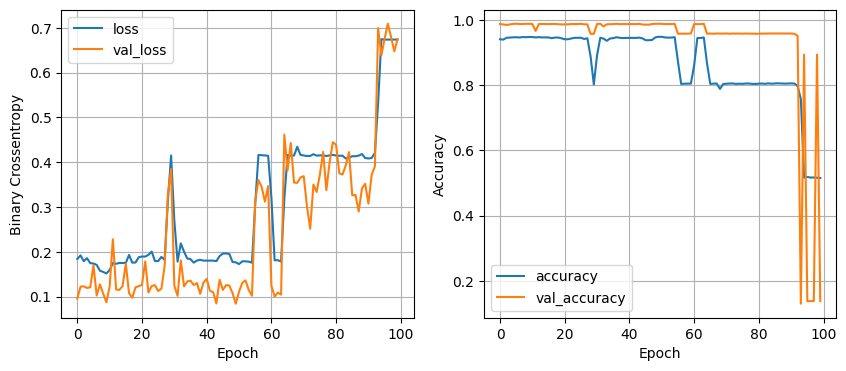

659/659 [==============================] - 1s 740us/step - loss: 0.6744 - accuracy: 0.1376
16 nodes, dropout_prob 0, lr 0.1, batch size 64


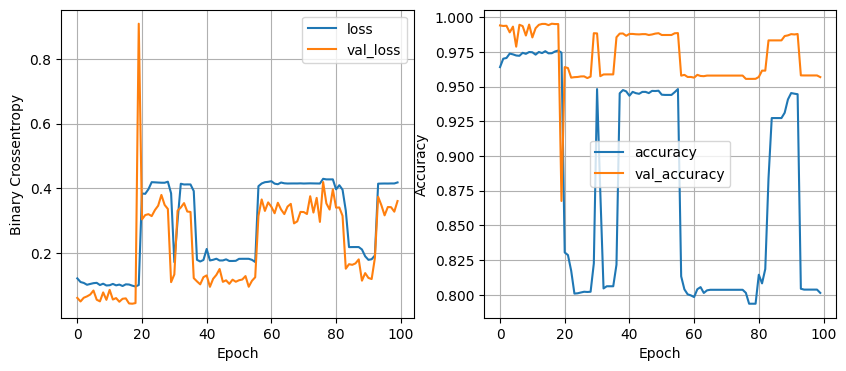

659/659 [==============================] - 1s 816us/step - loss: 0.3610 - accuracy: 0.9568
16 nodes, dropout_prob 0, lr 0.1, batch size 128


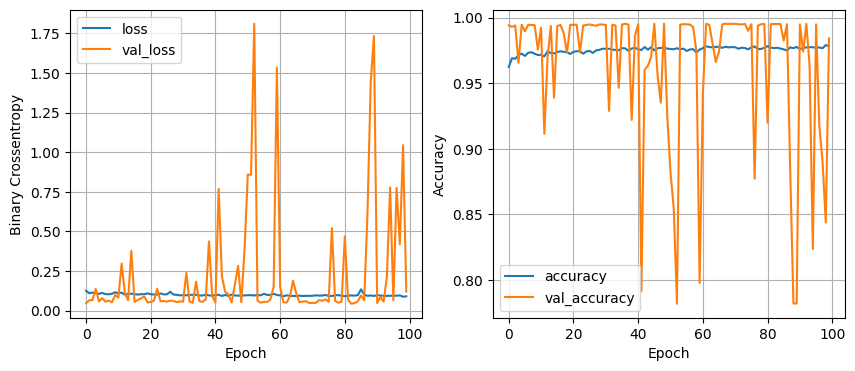

659/659 [==============================] - 1s 763us/step - loss: 0.1193 - accuracy: 0.9842
16 nodes, dropout_prob 0, lr 0.005, batch size 32


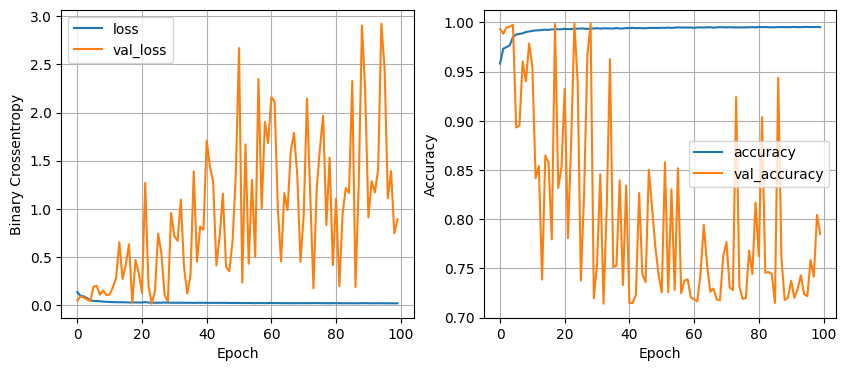

659/659 [==============================] - 1s 752us/step - loss: 0.8926 - accuracy: 0.7850
16 nodes, dropout_prob 0, lr 0.005, batch size 64


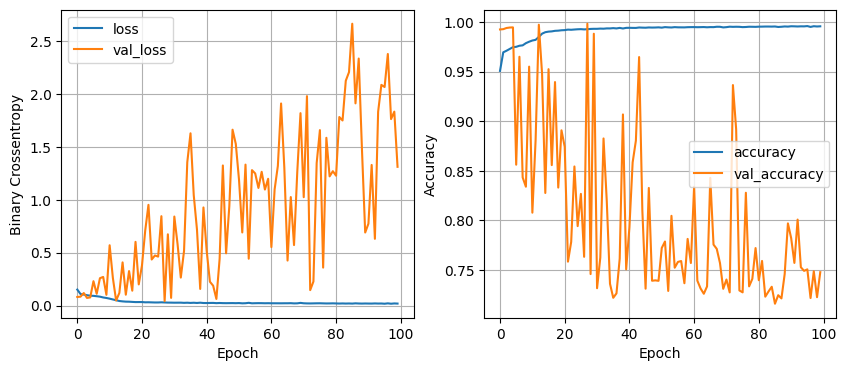

659/659 [==============================] - 1s 780us/step - loss: 1.3111 - accuracy: 0.7476
16 nodes, dropout_prob 0, lr 0.005, batch size 128


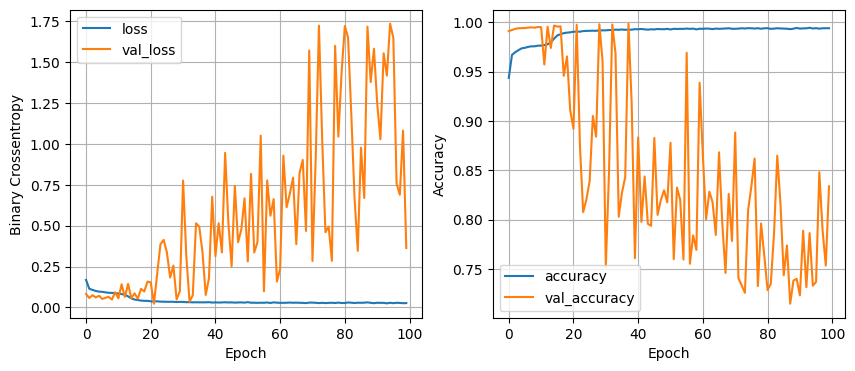

659/659 [==============================] - 1s 801us/step - loss: 0.3636 - accuracy: 0.8339
16 nodes, dropout_prob 0, lr 0.001, batch size 32


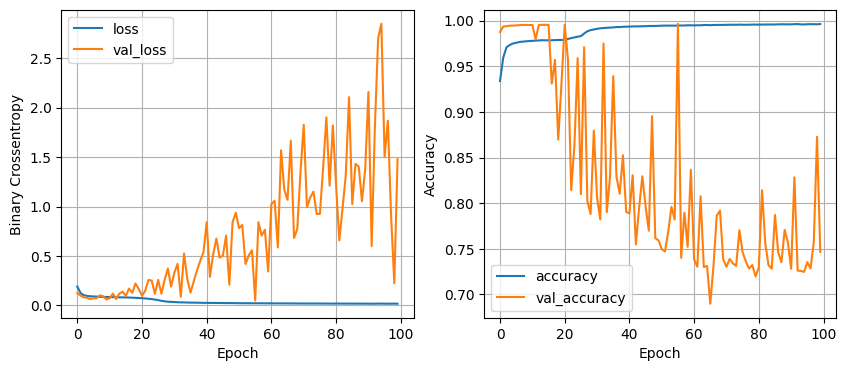

659/659 [==============================] - 1s 726us/step - loss: 1.4785 - accuracy: 0.7467
16 nodes, dropout_prob 0, lr 0.001, batch size 64


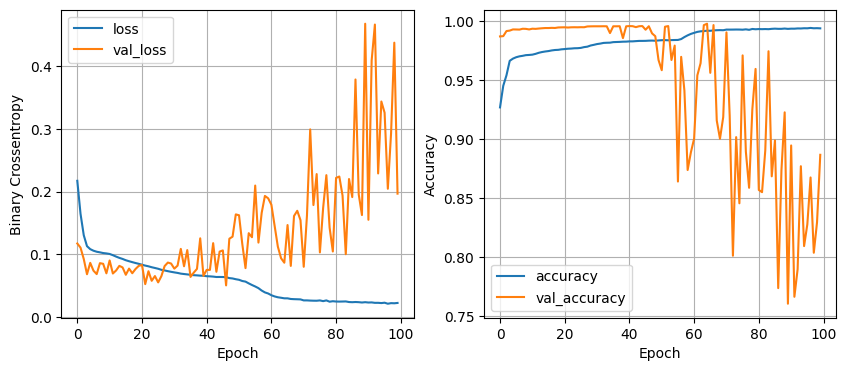

659/659 [==============================] - 0s 721us/step - loss: 0.1968 - accuracy: 0.8869
16 nodes, dropout_prob 0, lr 0.001, batch size 128


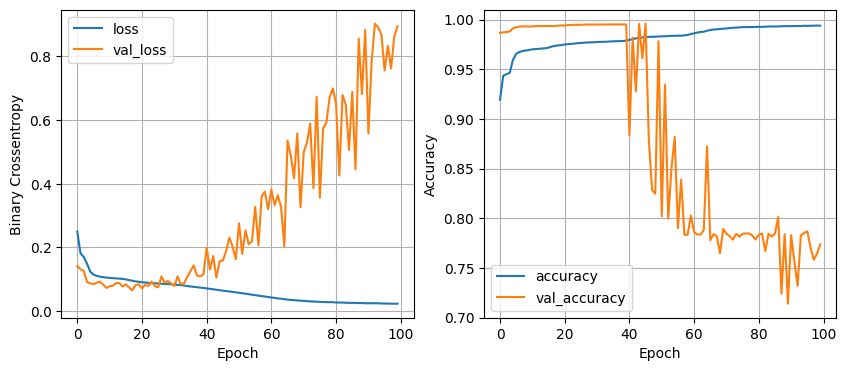

659/659 [==============================] - 1s 771us/step - loss: 0.8944 - accuracy: 0.7739
16 nodes, dropout_prob 0.2, lr 0.1, batch size 32


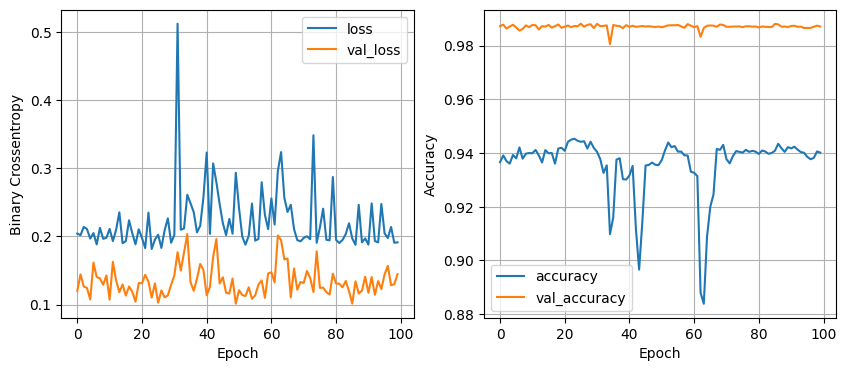

659/659 [==============================] - 0s 716us/step - loss: 0.1447 - accuracy: 0.9871
16 nodes, dropout_prob 0.2, lr 0.1, batch size 64


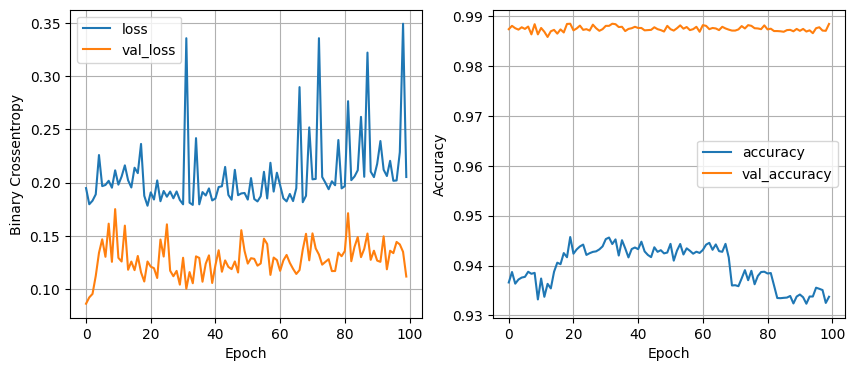

659/659 [==============================] - 1s 817us/step - loss: 0.1120 - accuracy: 0.9885
16 nodes, dropout_prob 0.2, lr 0.1, batch size 128


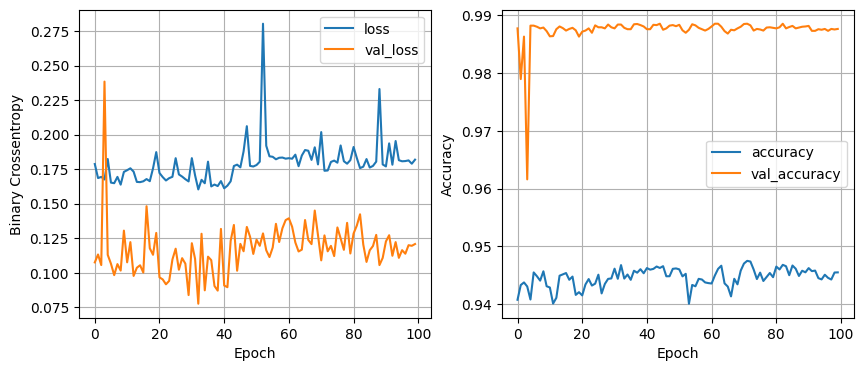

659/659 [==============================] - 1s 749us/step - loss: 0.1208 - accuracy: 0.9877
16 nodes, dropout_prob 0.2, lr 0.005, batch size 32


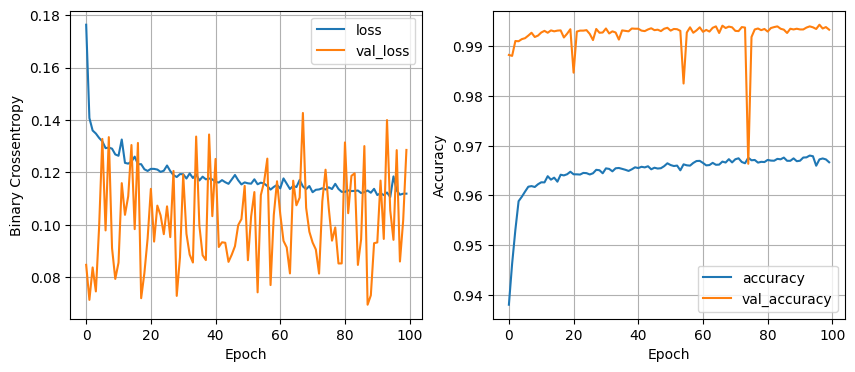

659/659 [==============================] - 1s 758us/step - loss: 0.1286 - accuracy: 0.9933
16 nodes, dropout_prob 0.2, lr 0.005, batch size 64


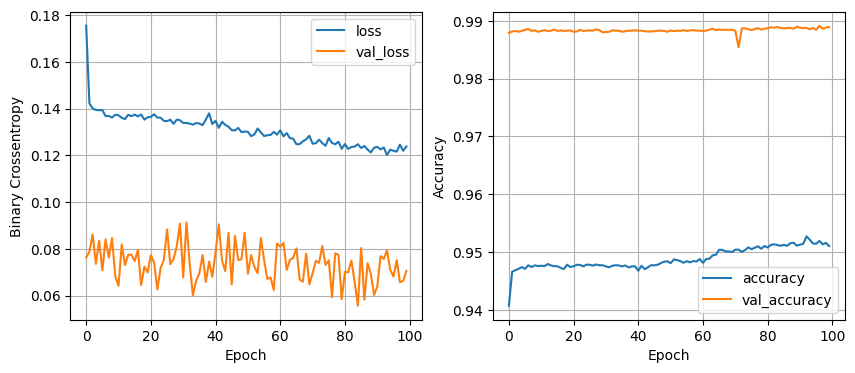

659/659 [==============================] - 1s 738us/step - loss: 0.0706 - accuracy: 0.9889
16 nodes, dropout_prob 0.2, lr 0.005, batch size 128


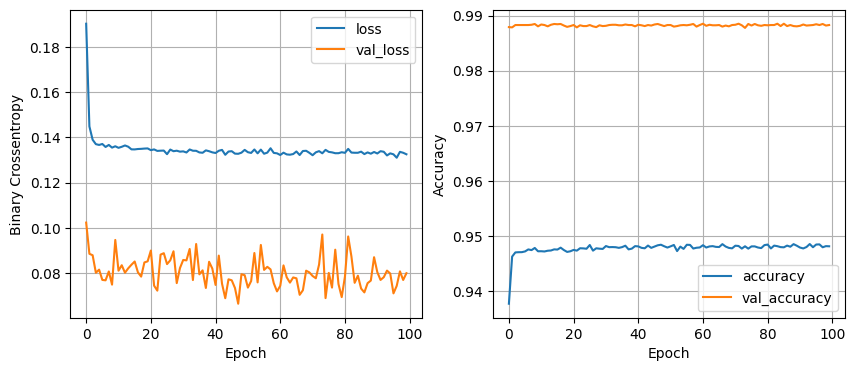

659/659 [==============================] - 1s 830us/step - loss: 0.0799 - accuracy: 0.9883
16 nodes, dropout_prob 0.2, lr 0.001, batch size 32


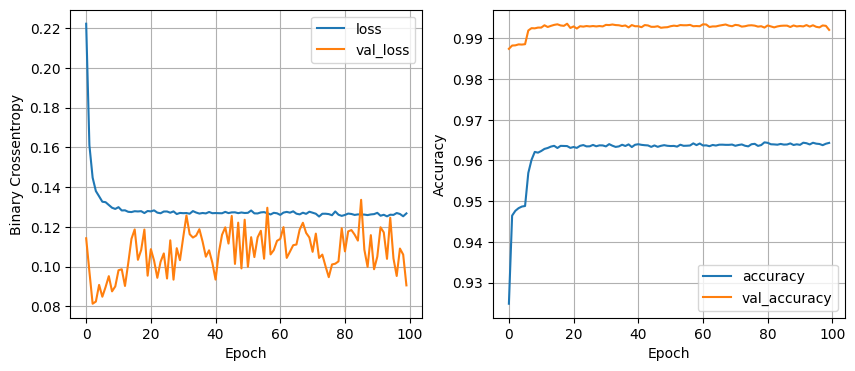

659/659 [==============================] - 1s 761us/step - loss: 0.0906 - accuracy: 0.9921
16 nodes, dropout_prob 0.2, lr 0.001, batch size 64


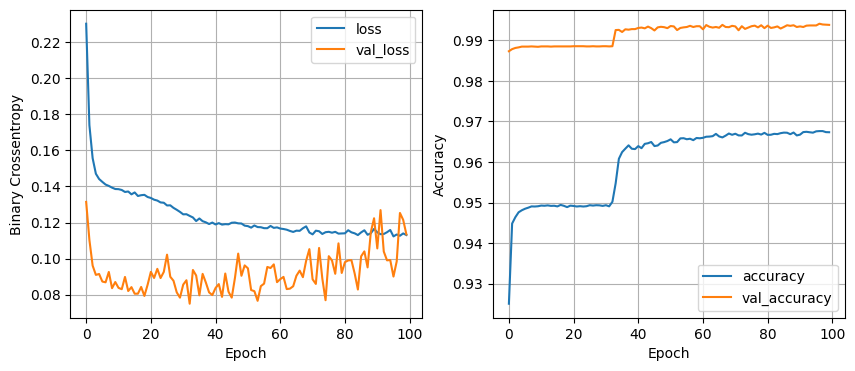

659/659 [==============================] - 0s 704us/step - loss: 0.1134 - accuracy: 0.9938
16 nodes, dropout_prob 0.2, lr 0.001, batch size 128


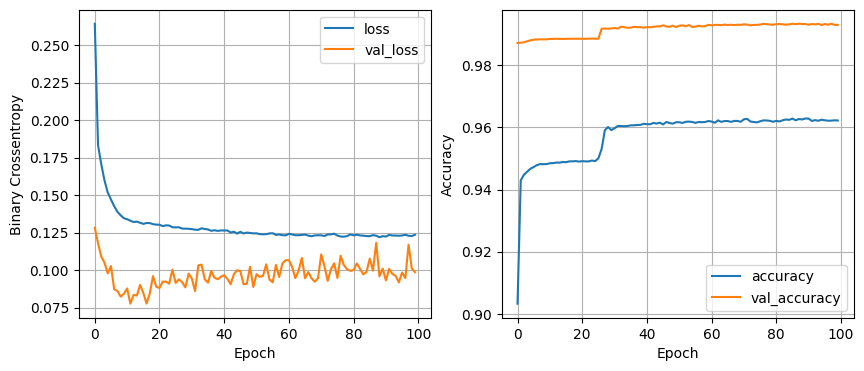

659/659 [==============================] - 0s 713us/step - loss: 0.0986 - accuracy: 0.9930
32 nodes, dropout_prob 0, lr 0.1, batch size 32


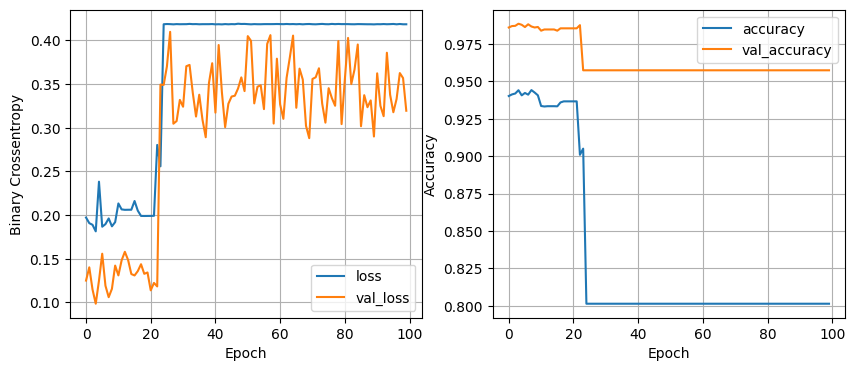

659/659 [==============================] - 1s 790us/step - loss: 0.3195 - accuracy: 0.9574
32 nodes, dropout_prob 0, lr 0.1, batch size 64


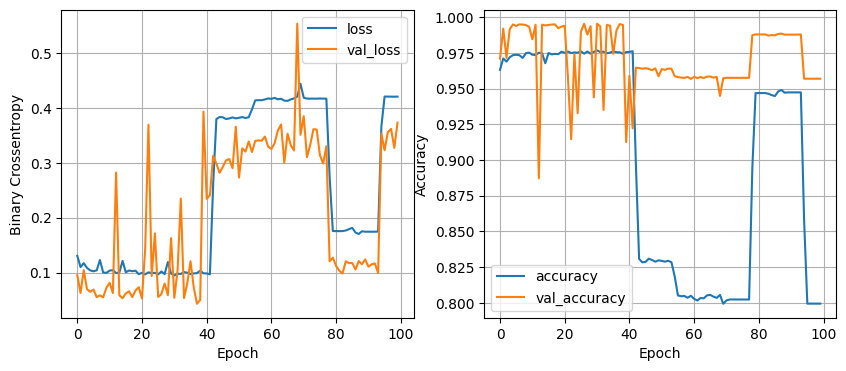

659/659 [==============================] - 1s 785us/step - loss: 0.3732 - accuracy: 0.9569
32 nodes, dropout_prob 0, lr 0.1, batch size 128


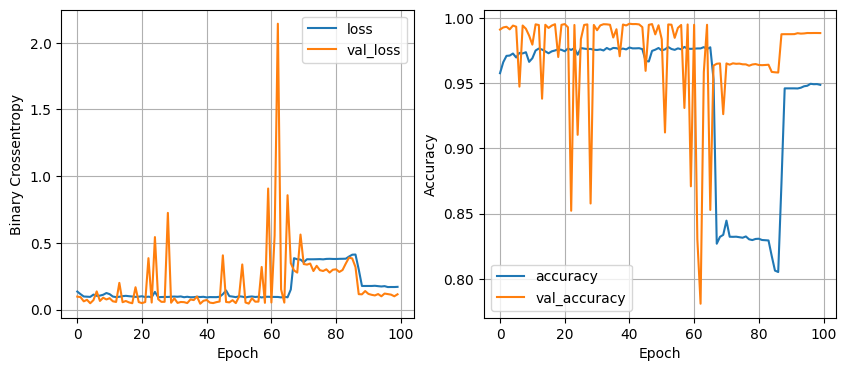

659/659 [==============================] - 1s 755us/step - loss: 0.1148 - accuracy: 0.9885
32 nodes, dropout_prob 0, lr 0.005, batch size 32


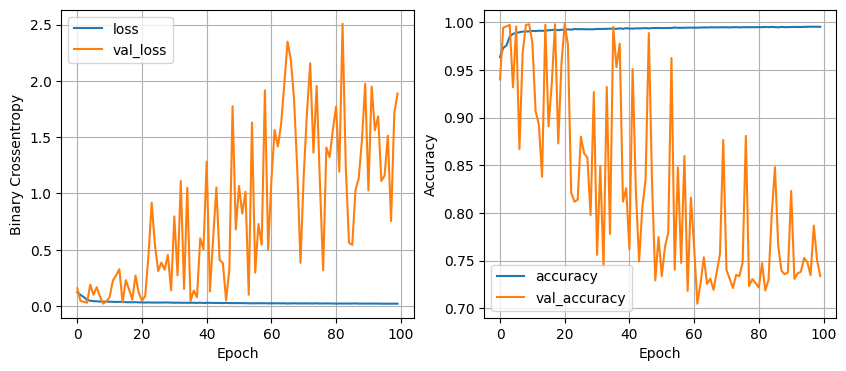

659/659 [==============================] - 1s 742us/step - loss: 1.8884 - accuracy: 0.7337
32 nodes, dropout_prob 0, lr 0.005, batch size 64


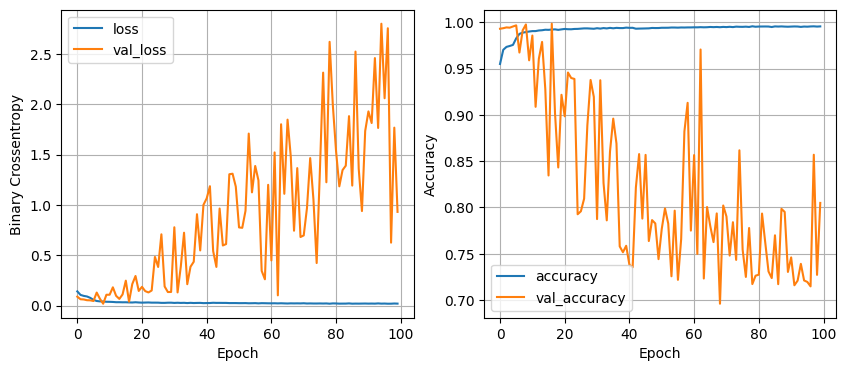

659/659 [==============================] - 1s 774us/step - loss: 0.9321 - accuracy: 0.8049
32 nodes, dropout_prob 0, lr 0.005, batch size 128


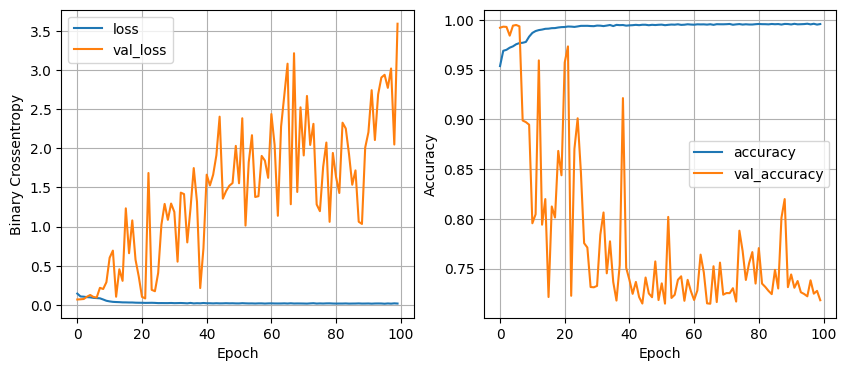

659/659 [==============================] - 1s 811us/step - loss: 3.5895 - accuracy: 0.7183
32 nodes, dropout_prob 0, lr 0.001, batch size 32


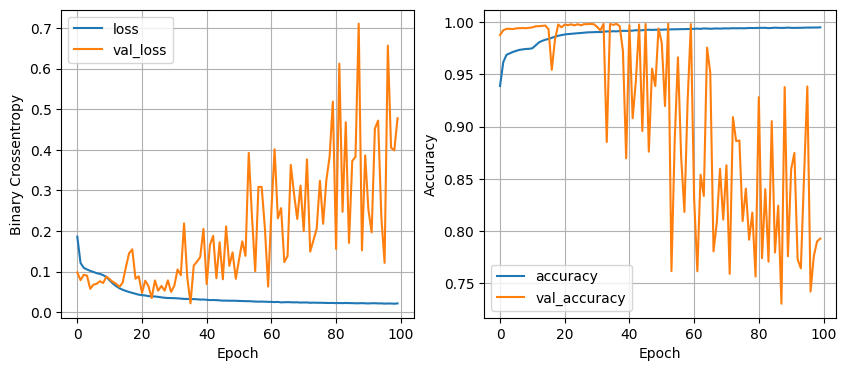

659/659 [==============================] - 1s 779us/step - loss: 0.4779 - accuracy: 0.7930
32 nodes, dropout_prob 0, lr 0.001, batch size 64


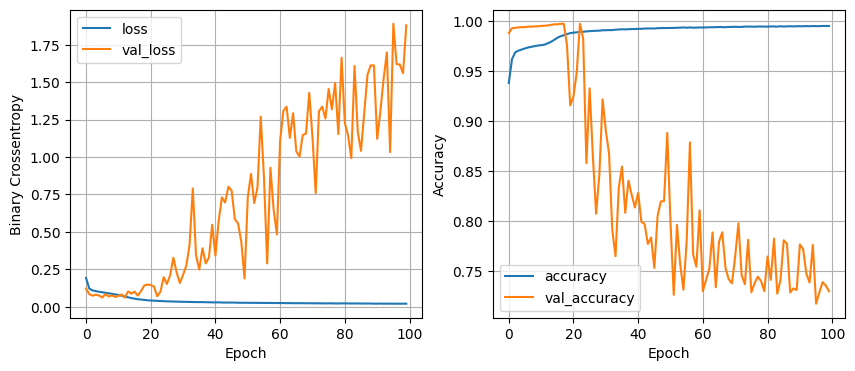

659/659 [==============================] - 0s 687us/step - loss: 1.8798 - accuracy: 0.7295
32 nodes, dropout_prob 0, lr 0.001, batch size 128


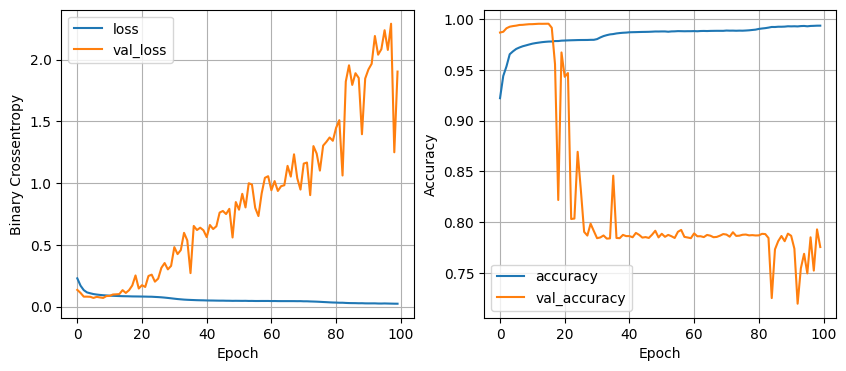

659/659 [==============================] - 1s 756us/step - loss: 1.9027 - accuracy: 0.7755
32 nodes, dropout_prob 0.2, lr 0.1, batch size 32


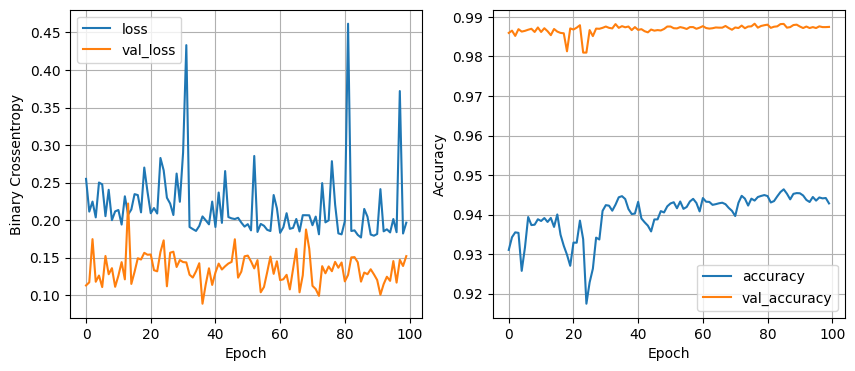

659/659 [==============================] - 1s 759us/step - loss: 0.1521 - accuracy: 0.9875
32 nodes, dropout_prob 0.2, lr 0.1, batch size 64


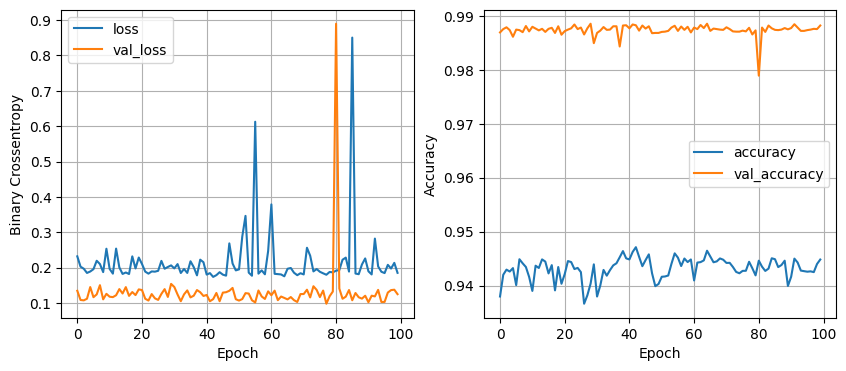

659/659 [==============================] - 1s 755us/step - loss: 0.1250 - accuracy: 0.9882
32 nodes, dropout_prob 0.2, lr 0.1, batch size 128


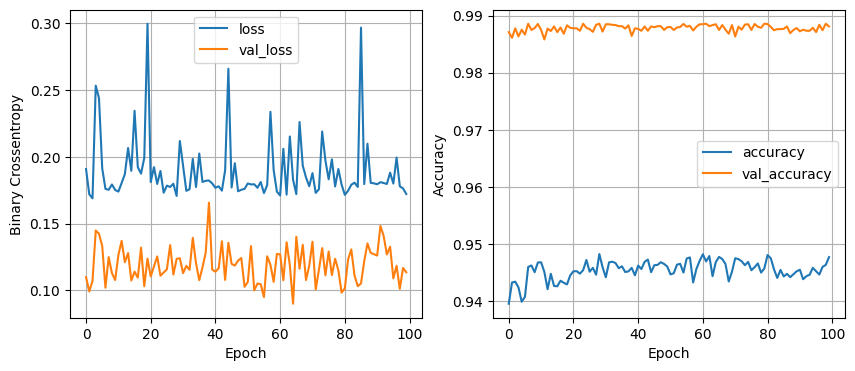

659/659 [==============================] - 1s 782us/step - loss: 0.1135 - accuracy: 0.9881
32 nodes, dropout_prob 0.2, lr 0.005, batch size 32


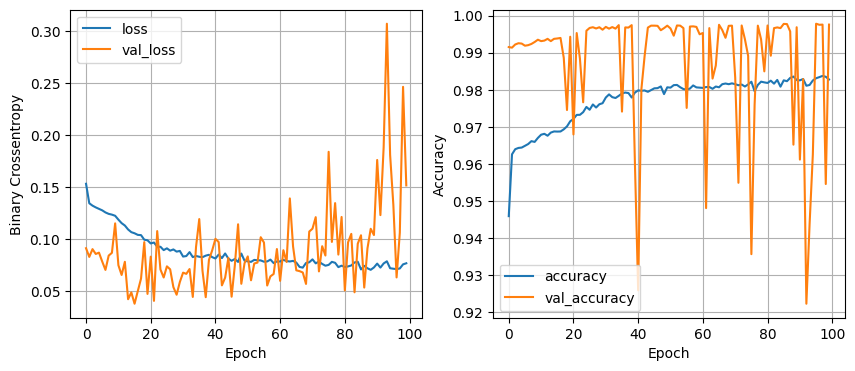

659/659 [==============================] - 1s 741us/step - loss: 0.1518 - accuracy: 0.9976
32 nodes, dropout_prob 0.2, lr 0.005, batch size 64


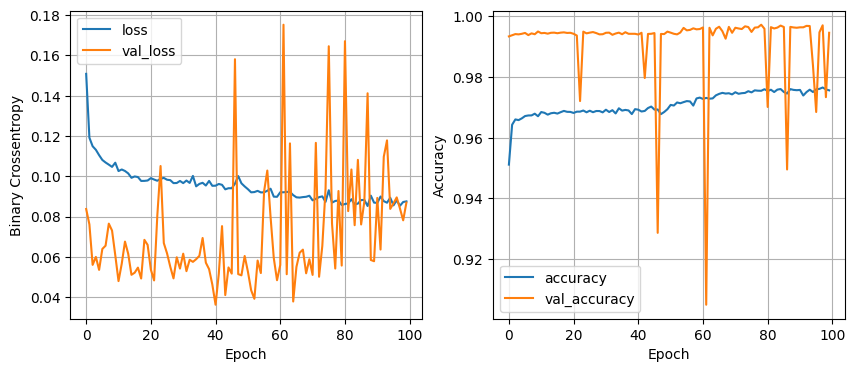

659/659 [==============================] - 0s 709us/step - loss: 0.0869 - accuracy: 0.9945
32 nodes, dropout_prob 0.2, lr 0.005, batch size 128


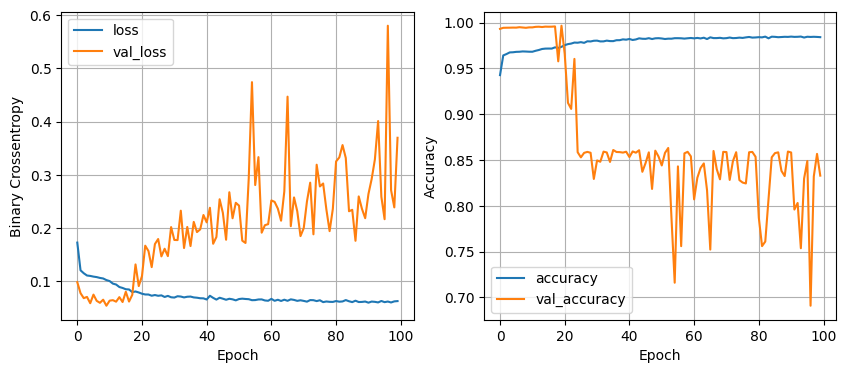

659/659 [==============================] - 0s 716us/step - loss: 0.3698 - accuracy: 0.8329
32 nodes, dropout_prob 0.2, lr 0.001, batch size 32


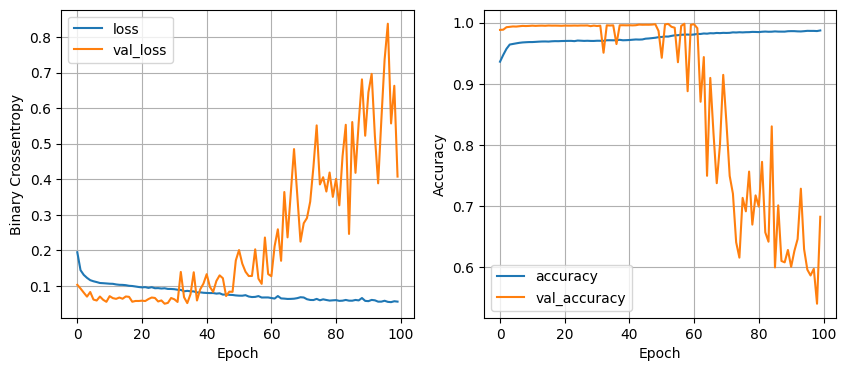

659/659 [==============================] - 0s 709us/step - loss: 0.4074 - accuracy: 0.6828
32 nodes, dropout_prob 0.2, lr 0.001, batch size 64


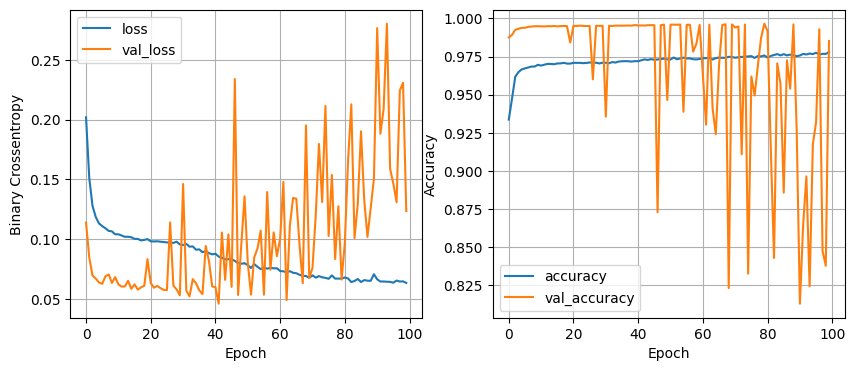

659/659 [==============================] - 1s 797us/step - loss: 0.1235 - accuracy: 0.9852
32 nodes, dropout_prob 0.2, lr 0.001, batch size 128


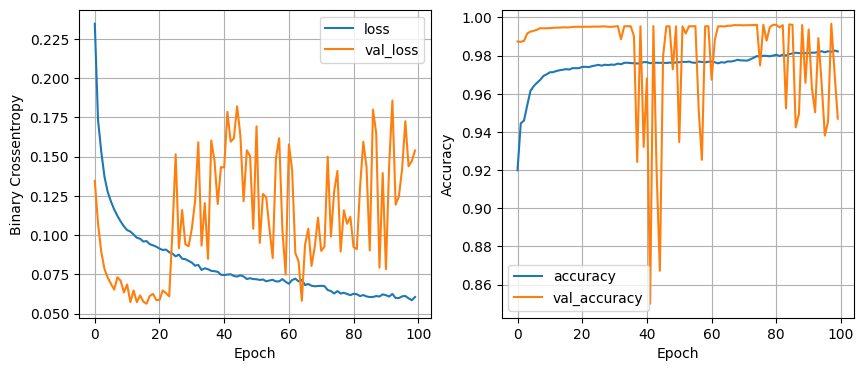

659/659 [==============================] - 1s 771us/step - loss: 0.1538 - accuracy: 0.9470
64 nodes, dropout_prob 0, lr 0.1, batch size 32


AssertionError: Nodes too big

In [29]:
least_val_loss = float('inf')
least_loss_model = None
epochs = 100
for nodes in [16, 32, 64]:
    for dropout_prob in [0, 0.2]:
        for lr in [0.1, 0.005, 0.001]:
            for batch_size in [32, 64, 128]:
                print(f"{nodes} nodes, dropout_prob {dropout_prob}, lr {lr}, batch size {batch_size}")
                model, history = nn_train(X_train=X_train, y_train=y_train, X_valid=X_valid, y_valid=y_valid, epochs=epochs, nodes=nodes, dropout_prob=dropout_prob, lr=lr, batch_size=batch_size)
                plot_nn(history=history)
                val_loss = model.evaluate(X_valid, y_valid)[0]
                if val_loss < least_val_loss:
                    least_val_loss = val_loss
                    least_loss_model = model
